Ok, let's get this starty parted.
The general design is As follows:
The model class will consist of:
    - a graph (networkx)
    - a state, that is a list/array, that maps integers(i.e. nodes) to species
    - a step function
        - interaction step
        - mutation step
    - a display function.
    
We will start with the graph and the display function, which will grant us eyes to aid in designing and testing the rest.

In [1]:
import networkx as nx
import random
from species import Species

import matplotlib.pyplot as plt
%matplotlib inline

Graph = nx.barabasi_albert_graph(150,2)
# Graph = nx.cycle_graph(1000) # just any old graph for testing purposes
N = Graph.number_of_nodes()
State = [Species([])]*N # The state will contain a mapping of nodes to the species that currently lives on it.

uncertainty = 0.1 # chance that a replicant mistakenly thinks it is contained in another species,
# even though it isn't. By the same token, the chance that it thinks it isn't contained, even though it is.
# CONFUSION!
# uncertainty is in the range (0,0.5).
# 0 = replicants have perfect vision
# 0.5 is maximal uncertainty

surrender_option_on = True # option to turn the ability of replicants to vote for surrender off.
# reduces the model to a fighting-only model, ie species fighting for survival, no consensual gene transfer

def display():
    
    color_map = [i.color for i in State]
    # nx.draw_circular(Graph, node_color=color_map)
    nx.draw_spring(Graph, node_color=color_map)

In [2]:
def d_mutate():
    """Apply a deletion mutation to a random node."""
    # pick a random node in the graph, i.e. an integer
    node = random.randint(0,N-1)
    # get the species currently living on that node
    species = State[node]
    # mutate the species and add it to the node in question.
    State[node] = species.deletion_mutation()
    
def i_mutate():
    """Apply an insertion mutation to a random node."""
    # pick a random node in the graph, i.e. an integer
    node = random.randint(0,N-1)
    # get the species currently living on that node
    species = State[node]
    # mutate the species and add it to the node in question.
    State[node] = species.insertion_mutation()

In [3]:
def mutation_step():
    """Mutates two random nodes."""
    d_mutate()
    i_mutate()

In [4]:
def interaction_step():
    """Chooses a random node and has it interact with one of its neighbors.
    We chose to uniformly sample nodes instead of edges, since we think,
    that it makes sense that nodes with few neighbors interact more with each of them.
    """
    # pick a random node
    a = random.randint(0, N-1)
    # get neighbors
    neighbors = [i for i in Graph[a]]
    # randomly select on neighbor
    b = random.choice(neighbors)
    
    # if the same species lives on both nodes, nothing happens, if not they interact
    # interact: one replaces the other, either violently or consensually
    if not State[a] == State[b]:
        
        if State[a].fitness > State[b].fitness:
            underdog_node = b
            favorite_node = a
            underdog = State[b]
            favorite = State[a]
        else:
            underdog_node = a
            favorite_node = b
            underdog = State[a]
            favorite = State[b]
        
        # now the genes in the underdog vote on wether to surrender or not.
        replicant_vote = [vote_surrender(i, underdog, favorite, underdog_node) for i in underdog.replicants]
        
        majority_vote = replicant_vote.count(True) > 0.5*len(replicant_vote)
        
        # print(underdog._name , " vs ", favorite._name , ": replicants voted: ", replicant_vote)
        # majority vote is determined by 0.5. Cutoff may be changed, depending on how strong the veto vote is.
        # i.e. how strongly a "surrender"-vote is weighted compared to a "fight"-vote.
        
        if majority_vote and surrender_option_on:
            # voted for surrender!
            # print(underdog._name, " surrendered to ", favorite._name )
            State[underdog_node] = favorite
            State[favorite_node] = favorite
        
        else:
            winner = fight(underdog, favorite)
            # print(underdog._name, " fought ", favorite._name, ". Winner = ", winner._name)

            # winner takes all: winner now replaces the loser on his node.
            State[underdog_node] = winner
            State[favorite_node] = winner

In [5]:
def fight(a,b):
    """A species a and b fight. Return the winner. Probabilistic"""
    p_a_wins = p_win(a,b)
    if p_a_wins > random.random():
        return a
    else:
        return b

def p_win(a,b):
    """Returns the probability that a wins against b. Deterministic.
    Optimisation with memoisation is possible!"""
    
    return a.fitness / (a.fitness + b.fitness)

In [6]:
def vote_surrender(replicant, underdog, favorite, underdog_node):
    """Does the replicant in question (element of underdog) want to fight
    the favorite, or surrender?
    Parameters the replicant is allowed to consider:
    1. fitness of his species (aka underdog)
    2. fitness of the species he is interacting with (aka favorite)
    3. fitness of his immediate neighbors (underdog.neighbors())
    4. uncertainty parameter.
    MEMOISABLE!
    """
    replicant_thinks_its_contained = replicant in favorite.replicants # is it contained or not?
    # Confusion step:
    if random.random() < uncertainty:
        replicant_thinks_its_contained = not replicant_thinks_its_contained # flip it with P=uncertainty!
    
    # the other very important information for risking surrender, is the surrounding species.
    neighbor_nodes = [i for i in Graph[underdog_node]] # list of neighbors
    neighbor_species = [State[i] for i in neighbor_nodes]
    # possibly remove the two combattants from the list? TODO ToDo
    
    # probability that the underdog wins agains a random neighbor
    # sum over all neighbors, with exception of the favorite.
    # also sum over other underdog and favorite nodes.
    
    p_u_beats_n = sum([p_win(underdog,n) for n in neighbor_species])/len(neighbor_species)
    
    # probability that the favorite wins against a neighbor
    p_f_beats_n = sum([p_win(underdog,n) for n in neighbor_species])/len(neighbor_species)
    
    # probability that the underdog wins against the favorite
    p_u_beats_f = p_win(underdog,favorite)
    
    if replicant_thinks_its_contained: # replicant thinks it is contained, but it knows it could be wrong and coniders pro and contra
        
        p_cont = 1 - uncertainty
        
        p_survive_if_surrender = p_cont * p_f_beats_n
        
        p_survive_if_fight = p_u_beats_f * p_u_beats_n + (1 - p_u_beats_f) * p_cont * p_f_beats_n
        
        return p_survive_if_surrender > p_survive_if_fight
        
        
    else: # replicant thinks it isn't contained, but it knows that it could be wrong
        
        # probability that replicant survives against neighborhood, given that it surrenders
        # on the offchance that it is contained after all.
        p_cont = uncertainty
        
        p_survive_if_surrender = p_cont * p_f_beats_n
        
        p_survive_if_fight = p_u_beats_f * p_u_beats_n + (1 - p_u_beats_f) * p_cont * p_f_beats_n
        
        return p_survive_if_surrender > p_survive_if_fight


In [7]:
def reps_in_common(a,b):
    "Return the number of Replicants Species a and Species b have in common."
    return len(set(a.replicants) & set(b.replicants)) # size of the intersection set.

In [8]:
mutation_ratio = 10 # ratio of interaction steps per mutation_step

def step():
    mutation_step()
    for i in range(0,mutation_ratio):
        interaction_step()

In [9]:
max_fitness_collector = []
max_replicants_len=[]
average_fitness_collector=[]

In [10]:
for i in range(0,100000):
    step()
    max_fitness_collector.append(max([node.fitness for node in State]))
    average_fitness_collector.append(sum([node.fitness for node in State])/N)
    max_replicants_len.append(max([len(node.replicants) for node in State]))

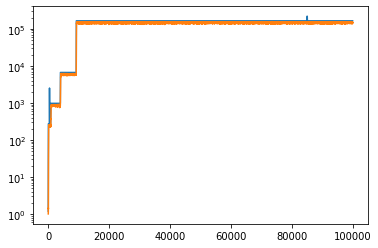

In [11]:
plt.yscale('log')
plt.plot(max_fitness_collector)
plt.plot(average_fitness_collector)

In [12]:
len(max_fitness_collector)

100000

(array([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 135.]),
 array([7.11764958e-01, 1.64037640e+04, 3.28068162e+04, 4.92098684e+04,
        6.56129207e+04, 8.20159729e+04, 9.84190251e+04, 1.14822077e+05,
        1.31225130e+05, 1.47628182e+05, 1.64031234e+05]),
 <BarContainer object of 10 artists>)

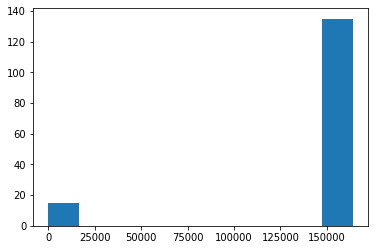

In [13]:
plt.hist([i.fitness for i in State])

In [14]:
zoo = sorted(set(State), key=lambda x: x.fitness,reverse=True)
print(len(State))
len(zoo)

150


12

In [15]:
[(reps_in_common(i,zoo[0]), len(i.replicants)) for i in zoo[:20]]

[(4, 4),
 (3, 3),
 (3, 3),
 (4, 5),
 (4, 5),
 (4, 5),
 (4, 5),
 (4, 5),
 (4, 5),
 (4, 5),
 (3, 3),
 (4, 6)]

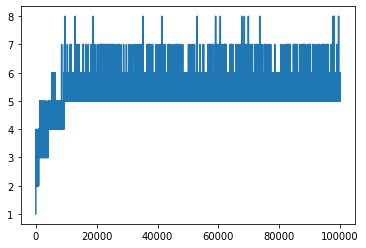

In [16]:
plt.plot(max_replicants_len)

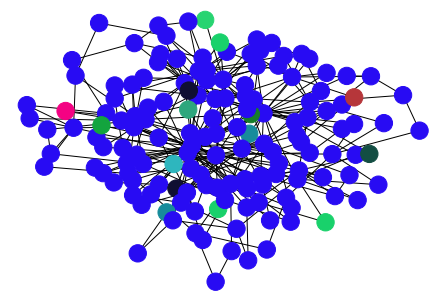

In [17]:
display()

array([-3.69173985e-03, -1.03163070e-03, -1.51299218e-04,  6.09639991e-06])

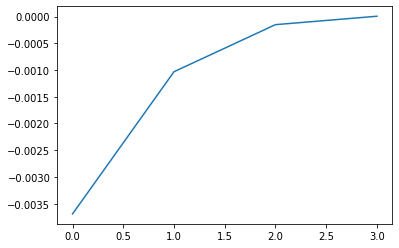

In [18]:
import numpy as np
cumulative_sum = np.cumsum([i.attribute for i in State[0].replicants[:]]) -1
#plt.yscale('symlog')
plt.plot(cumulative_sum)
cumulative_sum

(array([128.,   9.,   7.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 2. ,  5.1,  8.2, 11.3, 14.4, 17.5, 20.6, 23.7, 26.8, 29.9, 33. ]),
 <BarContainer object of 10 artists>)

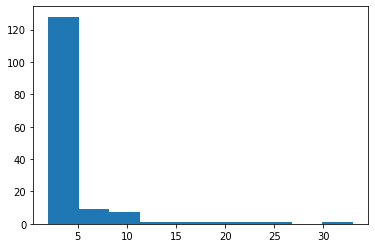

In [19]:
plt.hist([v for k,v in nx.degree(Graph)])